***
# Project 01 Speeddating dataset - Erinn Shu Han Lee, Lukáš Mikšovský
***

We have chosen for our python project a dataset called speeddating.csv. It includes data from an experimental speeddating project that took part between 2002 and 2004. The goal is to predict whether two individuals on a speeddate will match. 

In [488]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
#randomstate
random_seed = 123



## Data exploration and preprocessing
***
Requirements on preprocessing
Any two of the following operations are mandatory:
remove rows based on subsetting
derive new columns
use aggregation operators
treat missing values

In [489]:
df = pd.read_csv("speeddating.csv")
print('Dataset size: ', df.shape)
df.info()
df.head()

Dataset size:  (8378, 123)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 123 entries, has_null to match
dtypes: float64(59), object(64)
memory usage: 7.9+ MB


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,b'',1.0,b'female',21.0,27.0,6.0,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'0',b'0'
1,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,5.0,b'[6-8]',b'[5-6]',1.0,b'1',b'0',b'0'
2,b'',1.0,b'female',21.0,22.0,1.0,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',b'1',...,b'[0-3]',b'[3-5]',7.0,NaN,b'[6-8]',b'[0-4]',1.0,b'1',b'1',b'1'
3,b'',1.0,b'female',21.0,23.0,2.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',b'0',...,b'[0-3]',b'[3-5]',7.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1'
4,b'',1.0,b'female',21.0,24.0,3.0,b'[2-3]',b'Asian/Pacific Islander/Asian-American',b'Latino/Hispanic American',b'0',...,b'[0-3]',b'[3-5]',6.0,6.0,b'[6-8]',b'[5-6]',0.0,b'1',b'1',b'1'


In [490]:
for col in df.columns:
    if df[col].dtype == "object":
        oe = OrdinalEncoder()
        oe.fit(df[[col]])
        df[col] = oe.fit_transform(df[[col]])
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 123 entries, has_null to match
dtypes: float64(123)
memory usage: 7.9 MB


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0.0,1.0,0.0,21.0,27.0,6.0,2.0,1.0,3.0,0.0,...,0.0,1.0,7.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,21.0,22.0,1.0,0.0,1.0,3.0,0.0,...,0.0,1.0,7.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,21.0,22.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,7.0,NaN,1.0,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,21.0,23.0,2.0,1.0,1.0,3.0,0.0,...,0.0,1.0,7.0,6.0,1.0,1.0,0.0,1.0,1.0,1.0
4,0.0,1.0,0.0,21.0,24.0,3.0,1.0,1.0,4.0,0.0,...,0.0,1.0,6.0,6.0,1.0,1.0,0.0,1.0,1.0,1.0


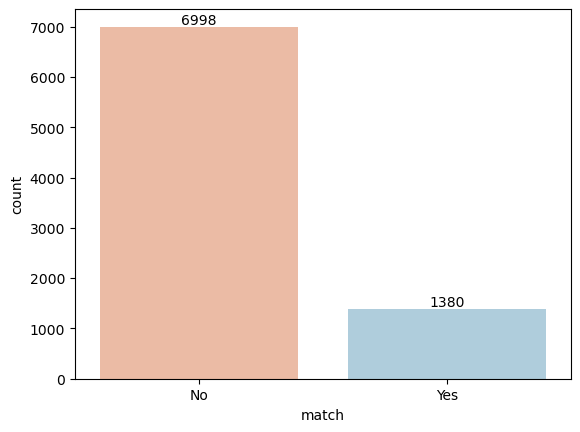

In [491]:
plt.figure()
ax = sns.countplot(x='match', data=df, palette='RdBu')
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks([0,1], ['No', 'Yes'])
plt.show()


As you can see from the bar plot, It unfortunately wasnt a match most of the time. The short date was'nt a success 6998 times. Match between the two participants occured 1380 times. That means that our dataset is a bit scewed towards the targer 0 = "no" and we need to keep that in mind when we evaluate the confussion matrix.  

In [492]:
print(df.isnull().sum())

has_null                0
wave                    0
gender                  0
age                    95
age_o                 104
                     ... 
d_guess_prob_liked      0
met                   375
decision                0
decision_o              0
match                   0
Length: 123, dtype: int64


## Imputing missing values

In [493]:
print(df.isnull().sum())

has_null                0
wave                    0
gender                  0
age                    95
age_o                 104
                     ... 
d_guess_prob_liked      0
met                   375
decision                0
decision_o              0
match                   0
Length: 123, dtype: int64


In [494]:
for i in df.columns[df.isnull().any(axis=0)]:
    df[i].fillna(df[i].mean(),inplace=True)
print(df.isnull().sum())

has_null              0
wave                  0
gender                0
age                   0
age_o                 0
                     ..
d_guess_prob_liked    0
met                   0
decision              0
decision_o            0
match                 0
Length: 123, dtype: int64


In [495]:
df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0.0,1.0,0.0,21.0,27.0,6.0,2.0,1.0,3.0,0.0,...,0.0,1.0,7.0,6.000000,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,21.0,22.0,1.0,0.0,1.0,3.0,0.0,...,0.0,1.0,7.0,5.000000,1.0,1.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,21.0,22.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,7.0,5.207523,1.0,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,21.0,23.0,2.0,1.0,1.0,3.0,0.0,...,0.0,1.0,7.0,6.000000,1.0,1.0,0.0,1.0,1.0,1.0
4,0.0,1.0,0.0,21.0,24.0,3.0,1.0,1.0,4.0,0.0,...,0.0,1.0,6.0,6.000000,1.0,1.0,0.0,1.0,1.0,1.0


# Model building
***
Requirements on model building
Use any classifier. Choose one of the following two options:

perform train/test split
use crossvalidation
Also, evaluate and compare at least two algorithms of different types (e.g. logistic regression and random forest).

Python: use any classifier from sklearn

In [496]:
X = df.drop(['match'], axis=1)
y = df['match']

In [497]:
#Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### Train test split

In [498]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6283, 122), (6283,), (2095, 122), (2095,))

### Logistic regression

In [499]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
log_pred = logreg.predict(X_test)
logreg.score(X_test, y_test)

0.9689737470167065

### Decision Tree classifier

In [500]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
tree.score(X_test, y_test)

1.0

### Logistic regression evaluation

In [501]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, log_pred))
print(confusion_matrix(y_test, log_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1728
         1.0       0.94      0.88      0.91       367

    accuracy                           0.97      2095
   macro avg       0.96      0.94      0.95      2095
weighted avg       0.97      0.97      0.97      2095

[[1706   22]
 [  43  324]]


### Decision Tree evaluation

In [502]:
print(classification_report(y_test, tree_pred))
print(confusion_matrix(y_test, tree_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1728
         1.0       1.00      1.00      1.00       367

    accuracy                           1.00      2095
   macro avg       1.00      1.00      1.00      2095
weighted avg       1.00      1.00      1.00      2095

[[1728    0]
 [   0  367]]


# Metaparameter tuning
***
Requirements on metaparameter tuning
If the chosen classifier has any metaparameters that can be tuned, use one of the following methods:

try several configurations and describe the best result in the final report
perform grid search or other similar automatic method
once you have tuned metaparameters on a dedicated development (training) set, e.g. with GridSearchCV, you can retrain the model on the complete training data, as e.g. described here for Python: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html and https://stackoverflow.com/questions/26962050/confused-with-repect-to-working-of-gridsearchcv
Python recommendation: sklearn.model_selection.GridSearchCV

In [503]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [504]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(X, y)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 1}
Best score is 0.8963921205428702


# Model evaluation
***
Requirements on model evaluation
report the accuracy on test set/crossvalidation
if you are performing binary classification task, involve also the ROC curve
make sure to use dedicated dataset for evaluation
Python: use model_selection.cross_val_score, plot the roc curve using sklearn.metrics.roc_curve R: print model learned using the caret package, the roc curve can be plotted using the plotROC package.